In [965]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re
import math
from collections import defaultdict
import pytz
import shin

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import expit, logit

from rapidfuzz.fuzz import ratio

things to look at: how accurate is the prematch probability when it ends (if a team has over 50% chance to win, how often do they actually win the game?)

Todo:

bets for totals markets

api for event outcome to backtest and look at distributions of prematch probabilities to outcome

bet again during halftime break

automating daily report

automate bet placements

rerunning fetchers and jupyter for non-filled orders periodically

In [966]:
date = '2025-12-16'
odds_sport = 'cbbm' #cbbm, cbbm2, cbbw2, cfb, cfb2, nba, nfl
kalshi_sport = 'ncaab' #ncaab, ncaabw, ncaaf, nba, nfl

In [967]:
#betus good for nba, pinnacle, betonline best for everything, fanduel pretty good

odds_df = pd.read_csv(f"../data_collection/updated_scripts/oddsapi_outputs/{date}/{odds_sport}_odds.csv")
odds_df.drop(columns=['league'], inplace=True)
odds_df.rename(columns={'price': 'odds'}, inplace=True)

odds_df['vig_prob'] = 1 / odds_df['odds']

def remove_vig_probs_add(df):
    df = df.copy()
    df['fair_prb'] = np.nan

    grouped = df.groupby(['game_id', 'bookmaker', 'market'])

    for _, group in grouped:
        if len(group) < 2:
            continue
        probs = group['vig_prob']
        total = probs.sum()
        if total == 0:
            continue
        fair_probs = (probs / total).round(4)
        df.loc[group.index, 'fair_prb'] = fair_probs

    return df

def remove_vig_probs_shin(df):
    df = df.copy()
    df['fair_prb'] = np.nan

    grouped = df.groupby(['game_id', 'bookmaker', 'market'])

    for _, group in grouped:
        if len(group) < 2:
            continue
        odds = group['odds'].values
        fair_probs = shin.calculate_implied_probabilities(odds)
        df.loc[group.index, 'fair_prb'] = fair_probs

    return df

def devig_probit(p1, p2):
    """if p1 <= 0 or p2 <= 0 or p1 >= 1 or p2 >= 1:
        total = p1 + p2
        return p1 / total, p2 / total
    if p1 + p2 <= 1:
        total = p1 + p2
        return p1 / total, p2 / total"""
  
    z1 = norm.ppf(p1)
    z2 = norm.ppf(p2)
    f = lambda lam: norm.cdf(z1 - lam) + norm.cdf(z2 - lam) - 1
    lam = brentq(f, -15, 15)
    
    q1 = norm.cdf(z1 - lam)
    q2 = norm.cdf(z2 - lam)
    return q1, q2

def remove_vig_probs_probit(df):
    df = df.copy()
    df['fair_prb'] = np.nan
    grouped = df.groupby(['game_id', 'bookmaker', 'market'])
    for _, group in grouped:
        if len(group) != 2:
            continue
        p1, p2 = group['vig_prob'].values
        q1, q2 = devig_probit(p1, p2)
        df.loc[group.index, 'fair_prb'] = [q1, q2]
    return df

def devig_logit(p1, p2):
    z1 = logit(p1)
    z2 = logit(p2)
    # Solve for λ such that logistic(z1 - λ) + logistic(z2 - λ) = 1
    f = lambda lam: expit(z1 - lam) + expit(z2 - lam) - 1
    lam = brentq(f, -50, 50)
    q1 = expit(z1 - lam)
    q2 = expit(z2 - lam)
    return q1, q2

def remove_vig_probs_logit(df):
    df = df.copy()
    df['fair_prb'] = np.nan
    grouped = df.groupby(['game_id', 'bookmaker', 'market'])
    for _, group in grouped:
        if len(group) != 2:
            continue
        p1, p2 = group['vig_prob'].values
        q1, q2 = devig_logit(p1, p2)
        df.loc[group.index, 'fair_prb'] = [q1, q2]
    return df

odds_df = remove_vig_probs_logit(odds_df)


odds_winners_df = odds_df[odds_df['market'] == 'h2h'].copy()
odds_spreads_df = odds_df[odds_df['market'] == 'spreads'].copy()
odds_spreads_df = odds_spreads_df.loc[(odds_spreads_df['point'].notna()) & (odds_spreads_df['point'] < 0)]
odds_totals_df  = odds_df[odds_df['market'] == 'totals'].copy()

# Average per-team fair probabilities across DraftKings/FanDuel/Pinnacle for winners_df
WEIGHTS = {
    "Pinnacle": 0.7,
    "BetOnline.ag": 0.1,
    "BetUS": 0.1,
    "FanDuel": 0.1
}

def wavg(x, df):
    idx = x.index
    bookmakers = df.loc[idx, 'bookmaker']
    w = np.array([WEIGHTS[b] for b in bookmakers])
    return np.average(x.values, weights=w)

mask = odds_winners_df['fair_prb'].notna()
avg_by_team = (
    odds_winners_df.loc[mask]
    .groupby(['game_id', 'team'])['fair_prb']
    .transform(lambda x: wavg(x, odds_winners_df))
    .round(4)
)
odds_winners_df.loc[mask, 'avg_fair_prb'] = avg_by_team
odds_winners_df.loc[~mask, 'avg_fair_prb'] = pd.NA

#Average fair probabilities for spreads for same game, point spread, and team
mask = odds_spreads_df['fair_prb'].notna()
avg_by_point = (
    odds_spreads_df.loc[mask]
    .groupby(['game_id', 'point', 'team'])['fair_prb']
    .transform(lambda x: wavg(x, odds_spreads_df))
    .round(4)
)
odds_spreads_df['avg_fair_prb'] = avg_by_point

#Average fair probabilities for totals for same game, point spread, direction (Over/Under)
mask = odds_totals_df['fair_prb'].notna()
avg_by_tot_point = (
    odds_totals_df.loc[mask]
    .groupby(['game_id', 'point', 'team'])['fair_prb']
    .transform(lambda x: wavg(x, odds_totals_df))
    .round(4)
)
odds_totals_df['avg_fair_prb'] = avg_by_tot_point

In [968]:
kalshi_winners_df = pd.read_csv(f"../data_collection/updated_scripts/kalshi_data_logs/{date}/{kalshi_sport}_winners.csv")
if kalshi_sport != 'ncaabw':
    kalshi_totals_df = pd.read_csv(f"../data_collection/updated_scripts/kalshi_data_logs/{date}/{kalshi_sport}_totals.csv")
    kalshi_spreads_df = pd.read_csv(f"../data_collection/updated_scripts/kalshi_data_logs/{date}/{kalshi_sport}_spreads.csv")

if (kalshi_sport == 'ncaaf') | (kalshi_sport == 'nfl'):
    kalshi_spreads_df['points'] = kalshi_spreads_df['title'].str.extract(r'over ([\d.]+) points\?').astype(float)
    kalshi_totals_df["points"] = kalshi_totals_df["ticker"].str.extract(r"-([0-9.]+)$").astype(float)
elif (kalshi_sport == 'ncaab') | (kalshi_sport == 'ncaabm') | (kalshi_sport == 'ncaabw') | (kalshi_sport == 'nba'):
    kalshi_spreads_df['points'] = kalshi_spreads_df['title'].str.extract(r'over ([\d.]+) Points\?').astype(float)
    kalshi_totals_df["points"] = kalshi_totals_df["ticker"].str.extract(r"-([0-9.]+)$").astype(float)

columns_to_drop = ['timestamp', 'market_type']
kalshi_winners_df.drop(columns=columns_to_drop, inplace=True)
if kalshi_sport != 'ncaabw':
    kalshi_spreads_df.drop(columns=columns_to_drop, inplace=True)
    kalshi_totals_df.drop(columns=columns_to_drop, inplace=True)

In [969]:
#get names from kalshi_winners_df
def extract_teams_from_winners(title):
    title = title.replace(" Winner?", "")
    if " at " in title:
        right, left = title.split(" at ", 1)
    elif " vs " in title:
        right, left = title.split(" vs ", 1)
    else:
        return pd.Series([None, None])  
    left = re.sub(r'\bSt\.$', 'St', left.strip())
    right = re.sub(r'\bSt\.$', 'St', right.strip())
    return pd.Series([left, right])

kalshi_winners_df[['home_team', 'away_team']] = kalshi_winners_df['title'].apply(extract_teams_from_winners)
unique_rows = kalshi_winners_df.drop_duplicates(subset=['home_team', 'away_team'])
flat_teams = pd.unique(unique_rows[['home_team', 'away_team']].values.ravel())
kalshi_winners_teams = flat_teams.tolist()

#get names from kalshi_totals_df
def extract_teams_from_totals(title):
    title = title.replace(": Total Points", "")
    if " at " in title:
        right, left = title.split(" at ", 1)
        left = re.sub(r'\bSt\.$', 'St', left.strip())
        right = re.sub(r'\bSt\.$', 'St', right.strip())
        return pd.Series([left, right])
    return None

if kalshi_sport != 'ncaabw':
    kalshi_totals_df[['home_team', 'away_team']] = kalshi_totals_df['title'].apply(extract_teams_from_totals)
    unique_rows = kalshi_winners_df.drop_duplicates(subset=['home_team', 'away_team'])
    flat_teams = pd.unique(unique_rows[['home_team', 'away_team']].values.ravel())
    kalshi_totals_teams = flat_teams.tolist()

#get names from kalshi_spreads_df
def extract_team_from_spreads(title):
    if " wins by " in title:
        team = title.split(" wins by ", 1)[0].strip()
        team = re.sub(r'\bSt\.$', 'St', team)
        return team
    return None

if kalshi_sport != 'ncaabw':
    kalshi_spreads_df['team'] = kalshi_spreads_df['title'].apply(extract_team_from_spreads)
    unique_teams_spread = kalshi_spreads_df['team'].drop_duplicates()
    kalshi_spreads_teams = unique_teams_spread.tolist()

In [970]:
def fuzzy_match_kalshi_to_odds(kalshi_teams, odds_team_names):
    matched_kalshi = []
    matched_odds = []
    candidates_dict = defaultdict(list)

    kalshi_sorted = sorted(kalshi_teams, key=lambda x: x[0] if x else '')
    remaining_odds = sorted(odds_team_names.tolist().copy())

    for kalshi_name in kalshi_sorted:
        candidates = []
        for odds_name in remaining_odds:
            if kalshi_name in odds_name:
                candidates.append(odds_name)
        if len(candidates) == 1:
            candidates_dict[candidates[0]].append(kalshi_name)
        elif len(candidates) > 1:
            best_fit = candidates[0]
            best_ratio = ratio(best_fit, kalshi_name)
            for name in candidates:
                curr_ratio = ratio(name, kalshi_name)
                if curr_ratio > best_ratio:
                    best_fit = name
                    best_ratio = curr_ratio
            candidates_dict[best_fit].append(kalshi_name)
    
    for odd, kalsh in candidates_dict.items():
        best_fit = kalsh[0]
        best_ratio = ratio(best_fit, odd)
        if len(kalsh) > 1:
            for name in kalsh:
                curr_ratio = ratio(name, odd)
                if curr_ratio > best_ratio:
                    best_fit = name
                    best_ratio = curr_ratio
        matched_odds.append(odd)
        matched_kalshi.append(best_fit)

    return matched_kalshi, matched_odds


# Winners / h2h
odds_teams_winners = odds_winners_df['team'].unique()
matched_kalshi_h2h, matched_odds_h2h = fuzzy_match_kalshi_to_odds(
    kalshi_winners_teams,
    odds_teams_winners
)

# Spreads
odds_teams_spreads = odds_spreads_df['team'].unique()
matched_kalshi_spreads, matched_odds_spreads = fuzzy_match_kalshi_to_odds(
    kalshi_spreads_teams,
    odds_teams_spreads
)

# Totals (match only Over/Under)
totals_odds_df = odds_df[odds_df['market'] == 'totals']
odds_totals_teams = pd.unique(totals_odds_df[['home_team', 'away_team']].values.ravel())
matched_kalshi_totals, matched_odds_totals = fuzzy_match_kalshi_to_odds(
    kalshi_totals_teams,
    odds_totals_teams
)

matched_names = {
    'h2h': {
        'kalshi': matched_kalshi_h2h,
        'odds': matched_odds_h2h
    },
    'spreads': {
        'kalshi': matched_kalshi_spreads,
        'odds': matched_odds_spreads
    },
    'totals': {
        'kalshi': matched_kalshi_totals,
        'odds': matched_odds_totals
    }
}


In [971]:
assert(len(matched_names['h2h']['kalshi']) == len(matched_names['h2h']['odds']))
assert(len(matched_names['spreads']['kalshi']) == len(matched_names['spreads']['odds']))
assert(len(matched_names['totals']['kalshi']) == len(matched_names['totals']['odds']))

In [972]:
odds_winners_df = odds_winners_df[
    odds_winners_df['home_team'].isin(matched_names['h2h']['odds']) |
    odds_winners_df['away_team'].isin(matched_names['h2h']['odds'])
].drop_duplicates(subset='team').sort_values(by='home_team').reset_index(drop=True)

kalshi_winners_df = kalshi_winners_df[
    kalshi_winners_df['home_team'].isin(matched_names['h2h']['kalshi']) |
    kalshi_winners_df['away_team'].isin(matched_names['h2h']['kalshi'])
].sort_values(by='home_team').reset_index(drop=True)

odds_spreads_df = odds_spreads_df[odds_spreads_df['team'].isin(matched_names['spreads']['odds'])
                                  ].sort_values(by='team').reset_index(drop=True)
kalshi_spreads_df = kalshi_spreads_df[kalshi_spreads_df['team'].isin(matched_names['spreads']['kalshi'])
                                      ].sort_values(by='team').reset_index(drop=True)

odds_totals_df = odds_totals_df[
    odds_totals_df['home_team'].isin(matched_names['totals']['odds']) |
    odds_totals_df['away_team'].isin(matched_names['totals']['odds'])
].sort_values(by='home_team').reset_index(drop=True)
kalshi_totals_df = kalshi_totals_df[
    (kalshi_totals_df['home_team'].isin(matched_names['totals']['kalshi'])) | 
    (kalshi_totals_df['away_team'].isin(matched_names['totals']['kalshi']))
    ].sort_values(by='home_team').reset_index(drop=True)


In [973]:
# Concatenate winners df

# Specify the columns to extract
kalshi_cols = ['ticker', 'yes_bid', 'yes_ask', 'no_bid', 'no_ask', 'home_team', 'away_team']
odds_cols = ['market', 'start_time', 'team', 'home_team', 'away_team', 'avg_fair_prb']

# Rename overlapping columns in odds to prevent clashes
odds_subset = odds_winners_df[odds_cols].rename(columns={
    'home_team': 'odds_home_team',
    'away_team': 'odds_away_team'
})

kalshi_subset = kalshi_winners_df[kalshi_cols].rename(columns={
    'home_team': 'kalshi_home_team',
    'away_team': 'kalshi_away_team'
})

combined_rows = []
len_matched = len(matched_names['h2h']['kalshi'])
matched_names_h2h = matched_names['h2h']

for i in range(len_matched):
    odds_name = matched_names_h2h['odds'][i]
    kalshi_name = matched_names_h2h['kalshi'][i]

    # Find the corresponding odds row
    odds_row = odds_subset.loc[odds_subset['team'] == odds_name]
    assert len(odds_row) == 1, f"Expected one row for {odds_name}, got {len(odds_row)}"

    # Find the two matching Kalshi rows
    kalshi_rows = kalshi_subset.loc[
        (kalshi_subset['kalshi_home_team'] == kalshi_name) |
        (kalshi_subset['kalshi_away_team'] == kalshi_name)
    ]
    assert len(kalshi_rows) == 2, f"Expected two rows for {kalshi_name}, got {len(kalshi_rows)}"

    # Extract rows
    k1 = kalshi_rows.iloc[0]
    k2 = kalshi_rows.iloc[1]
    midprice1 = (k1['yes_bid'] + k1['yes_ask']) / 2
    midprice2 = (k2['yes_bid'] + k2['yes_ask']) / 2

    # Extract scalar fair probability
    prb = odds_row['avg_fair_prb'].astype(float).item()

    # Choose the row closer to the odds probability
    if ((midprice1 - prb) ** 2) < ((midprice2 - prb) ** 2):
        combined_row = pd.concat([k1, odds_row.iloc[0]])
    else:
        combined_row = pd.concat([k2, odds_row.iloc[0]])

    combined_rows.append(combined_row)

combined_winners_df = pd.DataFrame(combined_rows).sort_values(by='odds_home_team')
combined_winners_df = combined_winners_df.reset_index(drop=True)

todo:
need to consider ev lifetime - should i lift the ask or keep refreshing ev and updating bids?

In [974]:
EDGE = 0.01
KELLY_UPPERBOUND = 1
BANKROLL = 400.00
Q1_WEIGHT = 1.00
Q2_WEIGHT = 1.00
Q3_WEIGHT = 1.00
Q4_WEIGHT = 1.00

midprice = (combined_winners_df['yes_bid'] + combined_winners_df['yes_ask']) / 2

edge_winners_df = combined_winners_df.loc[
    (combined_winners_df['avg_fair_prb'] >= combined_winners_df['yes_ask'] + EDGE) |
    ((1 - combined_winners_df['avg_fair_prb']) >= combined_winners_df['no_ask'] + EDGE)
].reset_index(drop=True)

midprice = (edge_winners_df['yes_bid'] + edge_winners_df['yes_ask']) / 2
edge_winners_df['midprice'] = midprice

edge_winners_df = edge_winners_df.loc[((edge_winners_df['avg_fair_prb'] > 0.15) & (edge_winners_df['avg_fair_prb'] < 0.49)) |
                                      ((edge_winners_df['avg_fair_prb'] > 0.51) & (edge_winners_df['avg_fair_prb'] < 0.85)) ]

midprice_yes = (edge_winners_df['yes_bid'] + edge_winners_df['yes_ask']) / 2
midprice_no = (edge_winners_df['no_bid'] + edge_winners_df['no_ask']) / 2

q_yes = edge_winners_df['avg_fair_prb']
q_no = 1 - edge_winners_df['avg_fair_prb'] 

#edge_winners_df['edge'] = np.where(q_yes > midprice_yes, q_yes - midprice_yes, q_no - midprice_no)
edge_winners_df['edge'] = np.where(q_yes > midprice_yes, q_yes - edge_winners_df['yes_ask'], q_no - edge_winners_df['no_ask'])

edge_winners_df['avg_fair_prb'] = np.where(q_yes > midprice_yes, edge_winners_df['avg_fair_prb'], 1 - edge_winners_df['avg_fair_prb'])

edge_winners_df['bid'] = np.where(q_yes > midprice_yes, edge_winners_df['yes_bid'], edge_winners_df['no_bid'])
edge_winners_df['ask'] = np.where(q_yes > midprice_yes, edge_winners_df['yes_ask'], edge_winners_df['no_ask'])

edge_winners_df['buy_direction'] = np.where(q_yes > midprice_yes, "yes", "no")
edge_winners_df.reset_index(drop=True, inplace=True)

assert (len(edge_winners_df) != 0), f"No bets on {odds_sport} today"

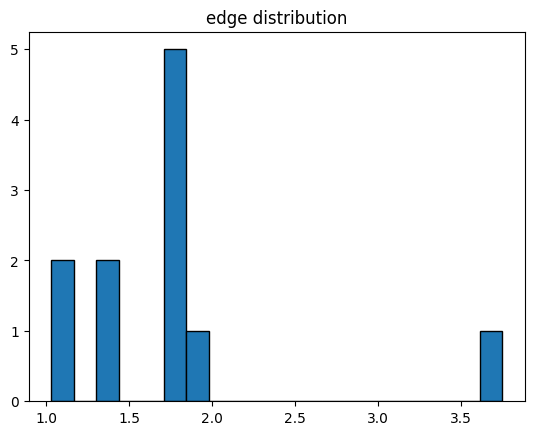

In [975]:
plt.hist(edge_winners_df['edge'] * 100, bins=20, edgecolor='black')
plt.title("edge distribution")
plt.show()

In [976]:
def compute_hitting_prob(row, sl, tp):
    """ 
    Assuming biased or unbiased random walk based on the fraction of previous month's
    up / total step count 
    """
    prob = row['avg_fair_prb']
    rv = prob
    if (prob >= 0.4) & (prob <= 0.6):
        rv = (prob - sl) / (tp - sl)
        return rv
    elif (prob >=0.3) & (prob < 0.4):
        p = None
        q = None
    elif (prob >= 0.2) & (prob < 0.3):
        p = None
        q = None
    elif (prob >= 0.10) & (prob < 0.2):
        p = None
        q = None
    elif (prob > 0.6) & (prob <= 0.7):
        p = None
        q = None
    elif (prob > 0.7) & (prob <= 0.8):
        p = None
        q = None
    elif (prob > 0.8) & (prob <= 0.9):
        p = None
        q = None
    rv = (1 - ((q / p) ** (prob - sl))) / (1 - ((q / p) ** (tp - sl)))
    return rv

In [977]:
KELLY_FRAC = 0.33

ev_dict = defaultdict(list)
for i in range(len(edge_winners_df)):
    row = edge_winners_df.iloc[i]
    #entry = row['bid']
    entry = row['ask']
    tp_list = []
    sl_list = []
    temp_tp = row['avg_fair_prb'] + 0.1
    temp_sl = entry - 0.1
    while (temp_tp < 1):
        tp_list.append(temp_tp)
        temp_tp = temp_tp + 0.01
    assert(len(tp_list) != 0)
    while (temp_sl > 0):
        sl_list.append(temp_sl)
        temp_sl = temp_sl - 0.01
    if len(sl_list) == 0:
        sl_list.append(0)
    for tp in tp_list:
        for sl in sl_list:
            if tp <= sl:
                continue
            if not (sl < entry < tp):
                continue
            if not (sl < row['avg_fair_prb'] < tp):
                continue
           
            #p = compute_hitting_prob(row, sl, tp)
            p = (row['avg_fair_prb'] - sl) / (tp - sl)
            kelly = entry * (p * (tp - entry) - (1 - p) * (entry - sl)) / ((tp - entry) * (entry - sl))
            kelly = kelly * KELLY_FRAC
            optimal_bet = kelly * BANKROLL
            num_contracts = optimal_bet // entry
            trading_cost_entry = np.ceil(100*(0.0175 * num_contracts * entry * (1 - entry))) / 100
            trading_cost_exit1 = np.ceil(100*(0.0175 * num_contracts * tp * (1 - tp))) / 100
            trading_cost_exit2 = np.ceil(100*(0.0175 * num_contracts * sl * (1 - sl))) / 100
            trading_cost_exit = (trading_cost_exit1 + trading_cost_exit2) / 2
            trading_cost = trading_cost_entry + trading_cost_exit
            profit = num_contracts * (tp - entry)
            loss = num_contracts * (entry - sl)
            ev = profit * p - loss * (1 - p) - trading_cost
            ev_dict[i].append([tp, sl, kelly, optimal_bet, num_contracts, trading_cost, profit, loss, ev])
        


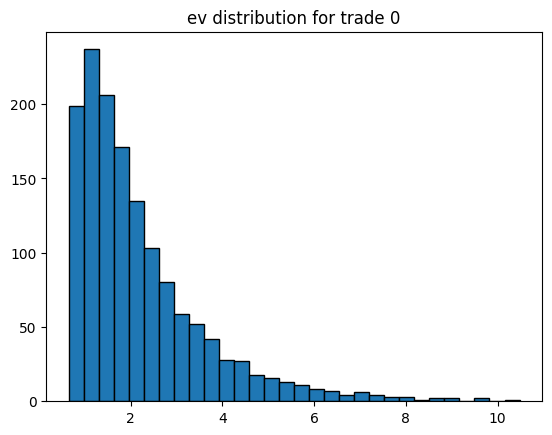

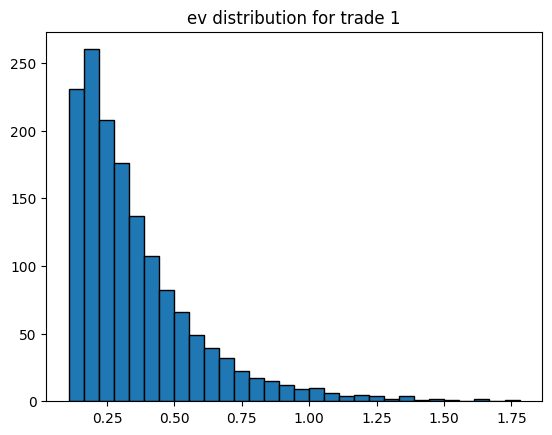

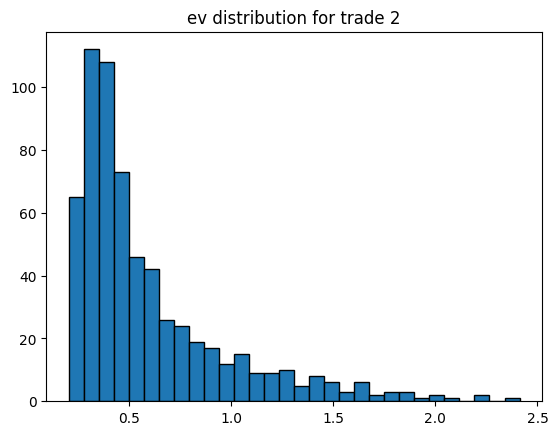

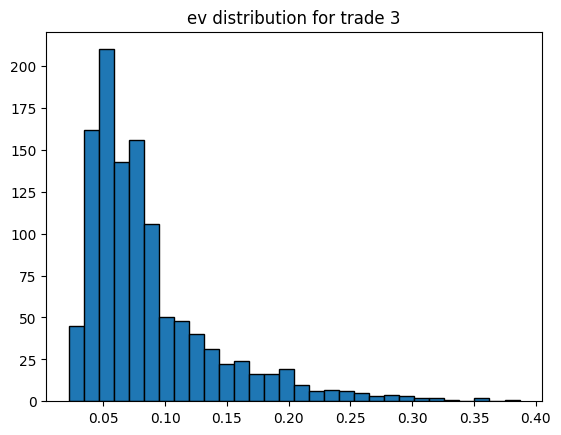

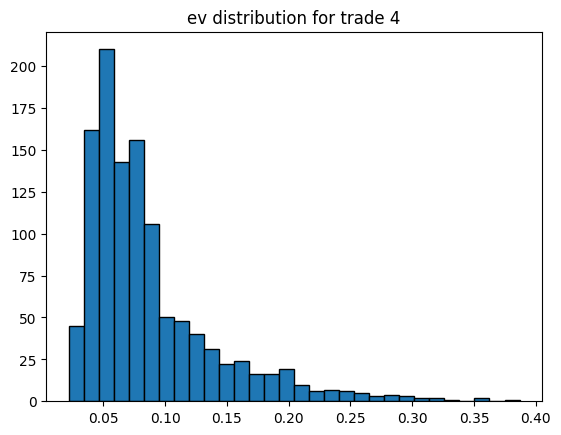

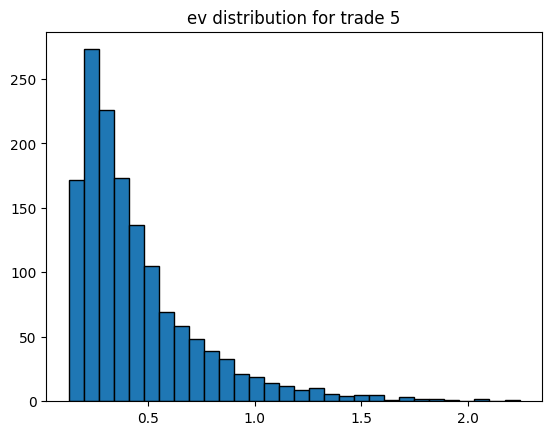

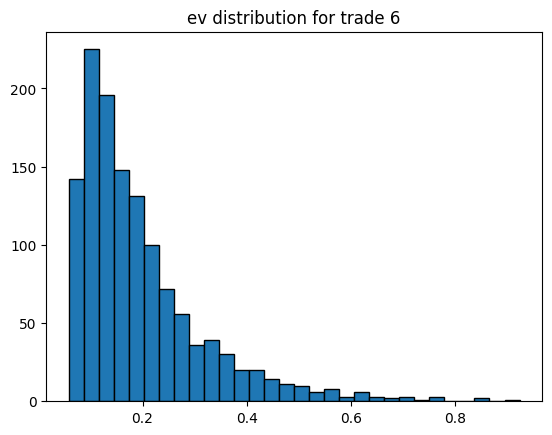

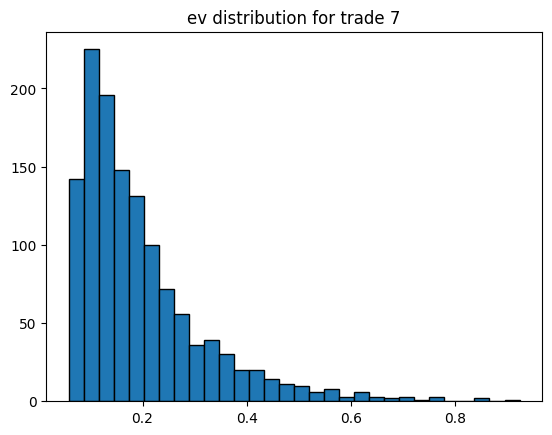

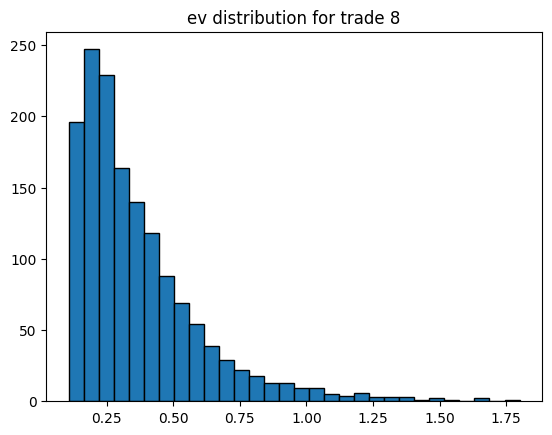

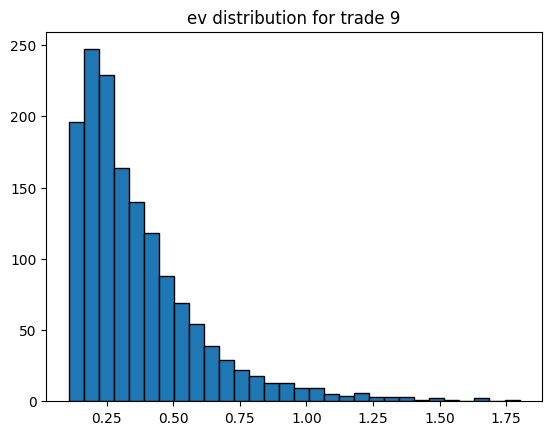

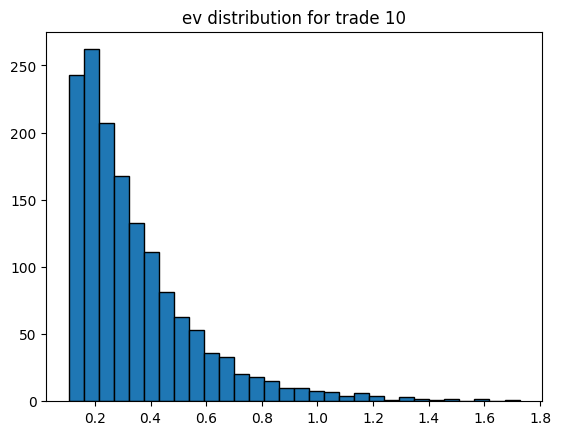

In [978]:
#plots the ev distribution for every trade for different pairs of (tp, sl)
for i in range(len(ev_dict)):
    trade_curr = ev_dict[i] 
    tp_list, sl_list, _, _, _, _, _, _, ev_list = map(list, zip(*trade_curr))
    plt.hist(ev_list, bins=30, edgecolor='black')
    plt.title(f"ev distribution for trade {i}")
    plt.show()
    

In [979]:
cols = ['tp', 'sl', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost', 'profit', 'loss', 'ev']

best_by_key = {
    k: max(trades, key=lambda x: x[8])   
    for k, trades in ev_dict.items()
    if trades
}

best_by_key = {
    k: [round(v[0], 2), round(v[1], 2), *v[2:]]
    for k, v in best_by_key.items()
}

keys = list(best_by_key.keys())
filtered_winners_df = edge_winners_df.iloc[keys].copy()
filtered_winners_df[cols] = np.array([best_by_key[k] for k in keys], dtype=float)



In [980]:
filtered_winners_df.drop(columns=['yes_bid','yes_ask', 'no_bid', 'no_ask', 'market', 'midprice'], inplace=True)
filtered_winners_df = filtered_winners_df[['ticker', 'start_time', 'kalshi_home_team', 'kalshi_away_team',
       'odds_home_team', 'odds_away_team', 'team', 'ask', 'avg_fair_prb', 'edge', 'buy_direction',
       'tp', 'sl', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost',
       'profit', 'loss', 'ev']]
filtered_winners_df['edge'] = filtered_winners_df['edge'] * 100
filtered_winners_df['optimal_bet'] = filtered_winners_df['optimal_bet'].round(2)

s = filtered_winners_df['start_time'].astype(str)
s = s.str.replace(r'\s+[A-Z]{3}$', '', regex=True)
dt = pd.to_datetime(s, errors='coerce')
filtered_winners_df['start_time'] = dt.dt.tz_localize('America/Chicago')

now = datetime.now(pytz.timezone('America/Chicago'))
#filtered_winners_df = filtered_winners_df.loc[filtered_winners_df['start_time'] > now].sort_values('odds_home_team').reset_index(drop=True)

dupe_mask = filtered_winners_df['kalshi_home_team'].duplicated(keep=False)
dupes = filtered_winners_df[dupe_mask]
uniques = filtered_winners_df[~dupe_mask]
best_dupes = dupes.loc[dupes.groupby('kalshi_home_team')['ev'].idxmax()]
filtered_winners_df = pd.concat([uniques, best_dupes], ignore_index=True)
filtered_winners_df.drop(columns=['start_time'], inplace=True)

In [981]:
filtered_winners_df

,ticker,kalshi_home_team,kalshi_away_team,odds_home_team,odds_away_team,team,ask,avg_fair_prb,edge,buy_direction,tp,sl,kelly,optimal_bet,num_contracts,trading_cost,profit,loss,ev
0,KXNCAAMBGAME-25DEC16BELEVAN-EVAN,Evansville,Belmont,Evansville Purple Aces,Belmont Bruins,Evansville Purple Aces,0.19,0.2076,1.76,yes,0.31,0.09,0.093837,37.53,197.0,1.055,23.1672,19.7,2.4122
1,KXNCAAMBGAME-25DEC16UTRGVLAM-UTRGV,Lamar,UT Rio Grande Valley,Lamar Cardinals,UT Rio Grande Valley Vaqueros,UT Rio Grande Valley Vaqueros,0.60,0.6189,1.89,no,0.72,0.50,0.314735,125.89,209.0,1.710,24.8501,20.9,2.2401
2,KXNCAAMBGAME-25DEC16SHUMASSL-MASSL,UMass Lowell,Sacred Heart,UMass Lowell River Hawks,Sacred Heart Pioneers,UMass Lowell River Hawks,0.57,0.5873,1.73,no,0.69,0.47,0.277419,110.97,194.0,1.630,22.7562,19.4,1.7262
3,KXNCAAMBGAME-25DEC16MTSTCP-MTST,Cal Poly,Montana St,Cal Poly Mustangs,Montana St Bobcats,Montana St Bobcats,0.55,0.5875,3.75,yes,0.69,0.45,0.495000,198.00,360.0,3.020,49.5000,36.0,10.4800
4,KXNCAAMBGAME-25DEC16MRSTGT-MRST,Georgia Tech,Marist,Georgia Tech Yellow Jackets,Marist Red Foxes,Marist Red Foxes,0.29,0.3003,1.03,yes,0.40,0.19,0.089366,35.75,123.0,0.880,13.5669,12.3,0.3869
5,KXNCAAMBGAME-25DEC16ORUMOSU-ORU,Missouri St,Oral Roberts,Missouri St Bears,Oral Roberts Golden Eagles,Oral Roberts Golden Eagles,0.33,0.3435,1.35,yes,0.44,0.23,0.129529,51.81,157.0,1.195,17.8195,15.7,0.9245
6,KXNCAAMBGAME-25DEC16UALRMORE-UALR,Morehead St,Little Rock,Morehead St Eagles,Arkansas-Little Rock Trojans,Arkansas-Little Rock Trojans,0.41,0.4275,1.75,yes,0.53,0.31,0.201511,80.60,196.0,1.630,23.0300,19.6,1.8000


In [982]:
total_loss = np.sum(filtered_winners_df['loss'])
total_profit = np.sum(filtered_winners_df['profit'])
total_ev = np.sum(filtered_winners_df['ev'])
print(f"{odds_sport} h2h portfolio summary:\n")
print(f"Max Loss: -{total_loss:.2f}")
print(f"Max Profit: {total_profit:.2f}")
print(f"Portfolio EV: {total_ev:.2f}")


cbbm h2h portfolio summary:

Max Loss: -143.60
Max Profit: 174.69
Portfolio EV: 19.97


**SPREADS**

In [ ]:
kalshi_cols = ['ticker', 'yes_bid', 'yes_ask', 'no_bid', 'no_ask', 'team', 'points', 'yes_spread', 'no_spread']
odds_cols = ['market', 'start_time', 'team', 'home_team', 'away_team', 'avg_fair_prb', 'point']

odds_subset = odds_spreads_df[odds_cols].rename(columns={
    'home_team': 'odds_home_team',
    'away_team': 'odds_away_team',
    'team': 'odds_team'
})

kalshi_subset = kalshi_spreads_df[kalshi_cols].copy()
kalshi_subset['midprice'] = (kalshi_subset['yes_bid'] + kalshi_subset['yes_ask']) / 2
kalshi_subset = kalshi_subset.loc[kalshi_subset['yes_spread'] <= 0.05]

combined_rows = []

for _, kalshi_row in kalshi_subset.iterrows():
    kalshi_team = kalshi_row['team']
    for _, odds_row in odds_subset.iterrows():
        odds_row = odds_row.copy()
        odds_team = odds_row['odds_team']
        if (kalshi_team in odds_team):
            if ((abs(odds_row['point']) == kalshi_row['points']) & (odds_row['avg_fair_prb'] > kalshi_row['midprice'])) or (
                (abs(odds_row['point']) > kalshi_row['points']) & (odds_row['avg_fair_prb'] >= kalshi_row['midprice'])):
                odds_row['buy_direction'] = "yes"
                combined_row = pd.concat([kalshi_row, odds_row])
                combined_rows.append(combined_row)
            elif ((abs(odds_row['point']) == kalshi_row['points']) & (odds_row['avg_fair_prb'] < kalshi_row['midprice'])) or (
                (abs(odds_row['point']) < kalshi_row['points']) & (odds_row['avg_fair_prb'] <= kalshi_row['midprice'])):
                odds_row['buy_direction'] = "no"
                combined_row = pd.concat([kalshi_row, odds_row])
                combined_rows.append(combined_row)

combined_spreads_df = pd.DataFrame(combined_rows).drop(columns=['team', 'market']).rename(
    columns={'odds_team': 'team', 'points': 'kalshi_pts', 'point': 'odds_pts'}).drop_duplicates(subset=['ticker', 'kalshi_pts', 'odds_pts'])                        
combined_spreads_df = combined_spreads_df.reset_index(drop=True)                    


In [ ]:
EDGE = 0.01
KELLY_UPPERBOUND = 1
BANKROLL = 200.00
Q1_WEIGHT = 1.00
Q2_WEIGHT = 1.00
Q3_WEIGHT = 1.00
Q4_WEIGHT = 1.00

midprice = (combined_spreads_df['yes_bid'] + combined_spreads_df['yes_ask']) / 2

edge_spreads_df = combined_spreads_df.loc[
    (combined_spreads_df['avg_fair_prb'] >= midprice + EDGE) |
    (combined_spreads_df['avg_fair_prb'] <= midprice - EDGE)
].reset_index(drop=True)

midprice_yes = (edge_spreads_df['yes_bid'] + edge_spreads_df['yes_ask']) / 2
midprice_no = (edge_spreads_df['no_bid'] + edge_spreads_df['no_ask']) / 2

q_yes = edge_spreads_df['avg_fair_prb']
q_no = 1 - edge_spreads_df['avg_fair_prb'] 

edge_spreads_df['edge'] = np.where(q_yes > midprice_yes, q_yes - midprice_yes, q_no - midprice_no)

edge_spreads_df['raw_kelly'] = np.where(q_yes > midprice_yes, edge_spreads_df['edge'] / (1 - midprice_yes),
                                        edge_spreads_df['edge'] / (1 - midprice_no))

total_kelly = edge_spreads_df['raw_kelly'].sum() 
if total_kelly >= 1: 
    edge_spreads_df['real_kelly'] = pd.DataFrame({
        'original': edge_spreads_df['raw_kelly'],
        'normalized': (edge_spreads_df['raw_kelly'] / total_kelly)
    }).min(axis=1)

# Define the real_kelly logic
def scale_kelly(row):
    k = row['raw_kelly']
    p = row['avg_fair_prb']
    
    if k == 0 or pd.isna(k):
        return 0
    if 0.05 <= p < 0.25:
        return min(Q1_WEIGHT * k, KELLY_UPPERBOUND)
    elif 0.25 <= p < 0.5:
        return min(Q2_WEIGHT * k, KELLY_UPPERBOUND)
    elif 0.5 <= p < 0.75:
        return min(Q3_WEIGHT * k, KELLY_UPPERBOUND)
    elif 0.75 <= p < 0.95:
        return min(Q4_WEIGHT * k, KELLY_UPPERBOUND)
    else:
        return 0 

# Apply to the DataFrame
edge_spreads_df['real_kelly'] = edge_spreads_df.apply(scale_kelly, axis=1)
edge_spreads_df['optimal_bet'] = edge_spreads_df['real_kelly'] * BANKROLL

q = edge_spreads_df['avg_fair_prb']
p = midprice_yes

num_contracts = np.where(q > p, edge_spreads_df['optimal_bet'] // edge_spreads_df['yes_bid'], edge_spreads_df['optimal_bet'] // edge_spreads_df['no_bid'])
edge_spreads_df['num_contracts'] = num_contracts
trading_cost = np.where(q > p, np.ceil(100*(0.0175 * num_contracts * edge_spreads_df['yes_bid'] * (1 - edge_spreads_df['yes_bid']))) / 100,
                        np.ceil(100*(0.0175 * num_contracts * edge_spreads_df['no_bid'] * (1 - edge_spreads_df['no_bid']))) / 100)
edge_spreads_df['trading_cost'] = trading_cost
profit = np.where(q > p, ((1 - edge_spreads_df['yes_bid']) * num_contracts - trading_cost), ((1 - edge_spreads_df['no_bid']) *  num_contracts - trading_cost))
edge_spreads_df['profit'] = profit
edge_spreads_df['ev'] = np.where(q > p, (profit * q_yes - (edge_spreads_df['optimal_bet'] + trading_cost) * (1 - q_yes)).round(2), 
                                 (profit * q_no - (edge_spreads_df['optimal_bet'] + trading_cost) * (1 - q_no)).round(2))
filtered_spreads_df = edge_spreads_df.loc[edge_spreads_df['ev'] > 0.10].reset_index(drop=True)

s = filtered_spreads_df['start_time'].astype(str)
s = s.str.replace(r'\s+[A-Z]{3}$', '', regex=True)
dt = pd.to_datetime(s, errors='coerce')
filtered_spreads_df['start_time'] = dt.dt.tz_localize('America/Chicago')

now = datetime.now(pytz.timezone('America/Chicago'))
filtered_winners_df = filtered_winners_df.loc[filtered_winners_df['start_time'] > now].sort_values('odds_home_team').reset_index(drop=True)
filtered_spreads_df = filtered_spreads_df.drop(columns=['start_time', 'yes_spread', 'no_spread', 'raw_kelly', 'real_kelly'])
filtered_spreads_df['edge'] = filtered_spreads_df['edge'] * 100

filtered spreads teams matching algo needs to be fixed.

In [ ]:
filtered_spreads_df

,ticker,yes_bid,yes_ask,no_bid,no_ask,kalshi_pts,midprice,team,odds_home_team,odds_away_team,avg_fair_prb,odds_pts,buy_direction,edge,optimal_bet,num_contracts,trading_cost,profit,ev
0,KXNCAAMBSPREAD-25DEC16QUCARK-ARK24,0.50,0.53,0.47,0.50,24.5,0.515,Arkansas Razorbacks,Arkansas Razorbacks,Queens University Royals,0.4973,-24.5,no,1.77,6.873786,14.0,0.07,7.35,0.24
1,KXNCAAMBSPREAD-25DEC16FSUDAY-DAY6,0.47,0.48,0.52,0.53,6.5,0.475,Dayton Flyers,Dayton Flyers,Florida St Seminoles,0.5049,-6.5,yes,2.99,11.390476,24.0,0.11,12.61,0.67
2,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX29,0.51,0.53,0.47,0.49,29.5,0.520,Texas Longhorns,Texas Longhorns,Le Moyne Dolphins,0.5000,-29.5,no,2.00,7.692308,16.0,0.07,8.41,0.32
3,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX29,0.51,0.53,0.47,0.49,29.5,0.520,Texas Tech Red Raiders,Texas Tech Red Raiders,N Colorado Bears,0.5000,-24.5,no,2.00,7.692308,16.0,0.07,8.41,0.32
4,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX29,0.51,0.53,0.47,0.49,29.5,0.520,Texas Tech Red Raiders,Texas Tech Red Raiders,N Colorado Bears,0.4918,-25.5,no,2.82,10.846154,23.0,0.11,12.08,0.75
5,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX26,0.58,0.63,0.37,0.42,26.5,0.605,Texas Tech Red Raiders,Texas Tech Red Raiders,N Colorado Bears,0.5000,-24.5,no,10.50,34.710744,93.0,0.38,58.21,11.56
6,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX26,0.58,0.63,0.37,0.42,26.5,0.605,Texas Tech Red Raiders,Texas Tech Red Raiders,N Colorado Bears,0.4918,-25.5,no,11.32,37.421488,101.0,0.42,63.21,13.51
7,KXNCAAMBSPREAD-25DEC16LMCTEX-TEX26,0.58,0.63,0.37,0.42,26.5,0.605,Texas Tech Red Raiders,Texas Tech Red Raiders,N Colorado Bears,0.5066,-25.0,no,9.84,32.528926,87.0,0.36,54.45,10.20
8,KXNCAAMBSPREAD-25DEC16BUTCONN-CONN15,0.47,0.49,0.51,0.53,15.5,0.480,UConn Huskies,UConn Huskies,Butler Bulldogs,0.5000,-15.5,yes,2.00,7.692308,16.0,0.07,8.41,0.32


In [ ]:
total_loss = np.sum(filtered_spreads_df['optimal_bet'])
total_profit = np.sum(filtered_spreads_df['profit'])
total_ev = np.sum(filtered_spreads_df['ev'])
print(f"{odds_sport} spreads portfolio summary:\n")
print(f"Max Loss: -{total_loss:.2f}")
print(f"Max Profit: {total_profit:.2f}")
print(f"Portfolio EV: {total_ev:.2f}")


cbbm spreads portfolio summary:

Max Loss: -156.85
Max Profit: 233.14
Portfolio EV: 37.89
